In [2]:
color_line_1 = 'royalblue'
color_line_2 = 'red'
color_scatter_1 = 'black' #'darkslategrey' #darkred
filled_color_1 = 'lightslategrey' #'lightcoral'

text_color_1 = 'royalblue'
text_color_2 = 'red'

style_theme = 'whitegrid'

# Cubic Hermitian Spline

In [1]:
import torch

def compute_cubic_spline(parameters: torch.Tensor, step: int, horizon: int):
    """ Given a set of spline parameters, and the point in the trajectory return the function value 
    
    Args :
        parameters (Tensor): Spline action parameter      of shape(batch, num_legs, 3, spline_param)              
        step          (int): The point in the curve in [0, horizon]
        horizon       (int): The length of the curve
        
    Returns : 
        actions    (Tensor): Discrete action              of shape(batch, num_legs, 3)
    """
    # Find the point in the curve q in [0,1]
    tau = step/(horizon)        
    q = (tau - 0.0)/(1.0-0.0)
    
    # Compute the spline interpolation parameters
    a =  2*q*q*q - 3*q*q     + 1
    b =    q*q*q - 2*q*q + q
    c = -2*q*q*q + 3*q*q
    d =    q*q*q -   q*q

    # Compute intermediary parameters 
    phi_1 = 0.5*(parameters[...,2]  - parameters[...,0]) # shape (batch, num_legs, 3)
    phi_2 = 0.5*(parameters[...,3]  - parameters[...,1]) # shape (batch, num_legs, 3)

    # Compute the spline
    actions = a*parameters[...,1] + b*phi_1 + c*parameters[...,2]  + d*phi_2 # shape (batch, num_legs, 3)

    return actions

In [3]:
import torch
import matplotlib.pyplot as plt

start = 0
stop = 4
steps=100

parameters = torch.tensor((0.2, 1.0, 1.0, 0.3, 1.3, 0.9, 1.5))

x_param = torch.arange(start=start-1, end=stop+2)
# print(x_param)

x = torch.linspace(start=start, end=stop, steps=steps*(stop-start))
# print(x)

spline = torch.empty_like(x)

for i in range(start,stop):
    # print('\nRange ',i)
    for j in range(steps):
        # print('step  ', steps*i + j)
        spline[steps*i + j] = compute_cubic_spline(parameters=parameters[i:i+4], step=j, horizon=steps)


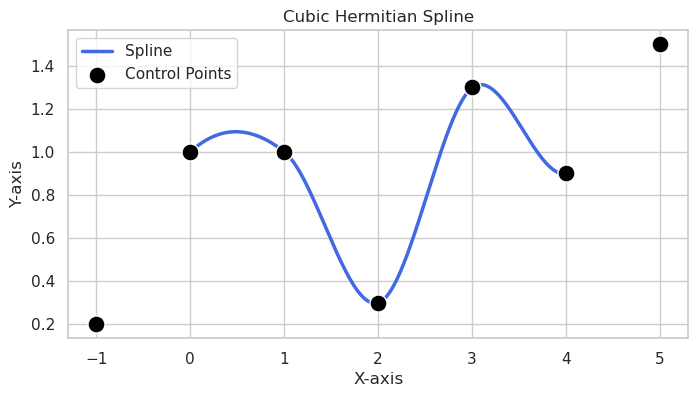

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x, y=spline, ax=ax, color=color_line_1, linewidth=2.5, label='Spline')

# Add a dot plot on top of the spline
sns.scatterplot(x=x_param, y=parameters, ax=ax, color=color_scatter_1, s=150, label='Control Points', zorder=5)

# Add titles and labels
ax.set_title("Cubic Hermitian Spline", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/A/cubic_hermite_spline.pdf", bbox_inches='tight')
plt.show()


# Spline Fitting

In [5]:
import torch

# Example data
x_data = torch.tensor([0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.9, 1.0])  # 5 data points
y_data = torch.tensor([0.3, 0.0, 0.4, 0.7, 0.8, 0.6, 0.8, 1.0])  # Example target values

# Construct the design matrix X
X = torch.stack([x_data**3, x_data**2, x_data, torch.ones_like(x_data)], dim=1)

# Solve the normal equations (X^T X) beta = X^T Y
XtX = X.t().mm(X)  # X^T X
XtY = X.t().mm(y_data.unsqueeze(1))  # X^T Y

# Compute the coefficients
a, b, c, d = torch.linalg.solve(XtX, XtY).squeeze()

# Define a cubic function (example with a, b, c, d as parameters)
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d


steps = 100

x_pred = torch.linspace(start=x_data[0], end=x_data[-1], steps=steps)
# print(x)

y_pred = cubic_function(x_pred, a, b, c, d)



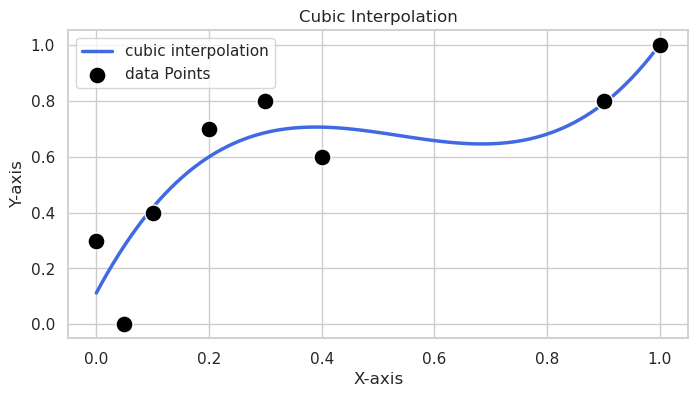

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_pred, y=y_pred, ax=ax, color=color_line_1, linewidth=2.5, label='cubic interpolation')

# Add a dot plot on top of the spline
sns.scatterplot(x=x_data, y=y_data, ax=ax, color=color_scatter_1, s=150, label='data Points', zorder=5)

# Add titles and labels
ax.set_title("Cubic Interpolation", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/A/cubic_interpolation.pdf", bbox_inches='tight')
plt.show()


# Spline fitting with constraints

In [7]:
import torch

# Construct the design matrix X
x_data_p = x_data[1:]
y_data_p = y_data[1:] - y_data[0]


X = torch.stack([x_data_p**3, x_data_p**2, x_data_p], dim=1)

# Solve the normal equations (X^T X) beta = X^T Y
XtX = X.t().mm(X)  # X^T X
XtY = X.t().mm(y_data_p.unsqueeze(1))  # X^T Y

# Compute the coefficients
a, b, c = torch.linalg.solve(XtX, XtY).squeeze()
d = y_data[0]

# Define a cubic function (example with a, b, c, d as parameters)
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d


steps = 100

x_pred_constraint = torch.linspace(start=x_data[0], end=x_data[-1], steps=steps)
# print(x)

y_pred_constraint = cubic_function(x_pred_constraint, a, b, c, d)



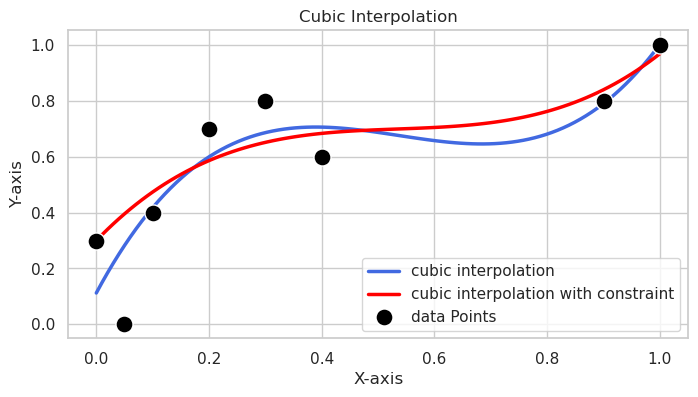

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_pred, y=y_pred, ax=ax, color=color_line_1, linewidth=2.5, label='cubic interpolation')

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_pred_constraint, y=y_pred_constraint, ax=ax, color=color_line_2, linewidth=2.5, label='cubic interpolation with constraint')

# Add a dot plot on top of the spline
sns.scatterplot(x=x_data, y=y_data, ax=ax, color=color_scatter_1, s=150, label='data Points', zorder=5)

# Add titles and labels
ax.set_title("Cubic Interpolation", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/A/cubic_interpolation_with_constaint.pdf", bbox_inches='tight')
plt.show()


# Bezier Curve

In [9]:
import torch

start = 0
stop = 1
steps=100

t = torch.linspace(start=start, end=stop, steps=steps*(stop-start))
# print(t)

cp0 = torch.tensor((0.0, 0.0))
cp1 = torch.tensor((0.2, 1.0))
cp2 = torch.tensor((1.8, 1.0))
cp3 = torch.tensor((2.0, 0.0))


def bezier_curve_deg_3(t, cp0, cp1, cp2, cp3):
    return cp0*((1-t)**3) + 3*cp1*t*((1-t)**2) + 3*cp2*(t**2)*(1-t) + cp3*(t**3)

x = bezier_curve_deg_3(t, cp0[0], cp1[0], cp2[0], cp3[0])
y = bezier_curve_deg_3(t, cp0[1], cp1[1], cp2[1], cp3[1])


tensor([0.0000, 0.2000, 1.8000, 2.0000])
tensor([0., 1., 1., 0.])


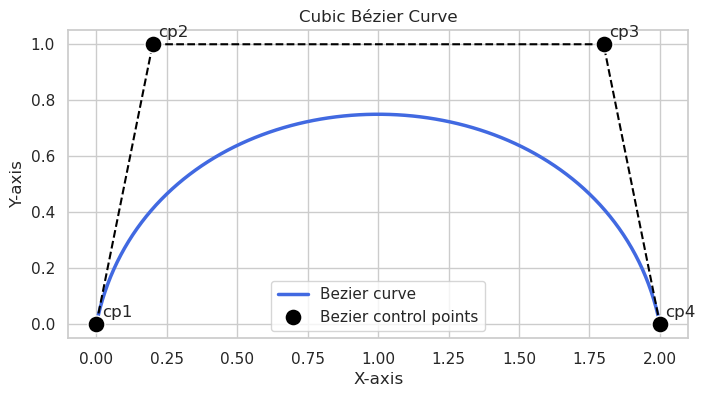

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x, y=y, ax=ax, color=color_line_1, linewidth=2.5, label='Bezier curve')

sns.lineplot(x=torch.stack((cp0[0], cp1[0]+0.0001, cp2[0]-0.0001, cp3[0])), y=torch.stack((cp0[1], cp1[1], cp2[1], cp3[1])), ax=ax, color=color_scatter_1, linestyle='--')

# Add a dot plot on top of the spline
sns.scatterplot(x=torch.stack((cp0[0], cp1[0], cp2[0], cp3[0])), y=torch.stack((cp0[1], cp1[1], cp2[1], cp3[1])), ax=ax, color=color_scatter_1, s=150, label='Bezier control points', zorder=5)

# Annotate the control points
control_points = ['cp1', 'cp2', 'cp3', 'cp4']
for i, (x_val, y_val) in enumerate(zip([cp0[0], cp1[0], cp2[0], cp3[0]], [cp0[1], cp1[1], cp2[1], cp3[1]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(15,5), ha='center')

print(torch.stack((cp0[0], cp1[0], cp2[0], cp3[0])))
print(torch.stack((cp0[1], cp1[1], cp2[1], cp3[1])))

# Add titles and labels
ax.set_title("Cubic Bézier Curve", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/simple_bezier_curve.pdf", bbox_inches='tight')
plt.show()


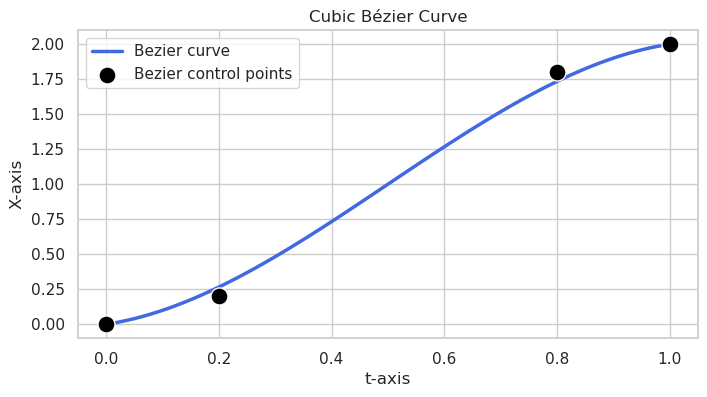

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=t, y=x, ax=ax, color=color_line_1, linewidth=2.5, label='Bezier curve')


# Add a dot plot on top of the spline
sns.scatterplot(x=torch.tensor((0.0, 0.2, 0.8 ,1.0)) ,y=torch.stack((cp0[0], cp1[0], cp2[0], cp3[0])), ax=ax, color=color_scatter_1, s=150, label='Bezier control points', zorder=5)


# Add titles and labels
ax.set_title("Cubic Bézier Curve", fontsize=12)
ax.set_xlabel("t-axis", fontsize=12)
ax.set_ylabel("X-axis", fontsize=12)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
# plt.savefig("thesis image/B/simple_bezier_curve.pdf", bbox_inches='tight')
plt.show()


# Swing Trajectory

## Swing trajectory Position

In [134]:
import torch

start = 0
stop = 1
steps=100

t = torch.linspace(start=start, end=stop, steps=steps*(stop-start))
# print(t)

p0 = torch.tensor((0.0, 0.0, 0.05))
p1 = torch.tensor((0.1, 0.1, 0.25))
p2 = torch.tensor((0.2, 0.2, 0.15))

# Point for the swing traj plot
# p0 = torch.tensor((0.0, 0.0, 0.00))
# p1 = torch.tensor((0.1, 0.1, 0.10))
# p2 = torch.tensor((0.2, 0.2, 0.0))
p0 = torch.tensor((0.00, 0.00, 0.00))
p1 = torch.tensor((0.05, 0.05, 0.10))
p2 = torch.tensor((0.10, 0.10, 0.0))


cp0_1 = torch.tensor((p0[0], p0[1], p0[2]))
cp1_1 = torch.tensor((p0[0], p0[1], p0[2]))
cp2_1 = torch.tensor((p0[0], p0[1], p1[2]))
cp3_1 = torch.tensor((p1[0], p1[1], p1[2]))

cp0_2 = torch.tensor((p1[0], p1[1], p1[2]))
cp1_2 = torch.tensor((p2[0], p2[1], p1[2]))
cp2_2 = torch.tensor((p2[0], p2[1], p2[2]))
cp3_2 = torch.tensor((p2[0], p2[1], p2[2]))


def bezier_curve_deg_3(t, cp0, cp1, cp2, cp3):
    return cp0*((1-t)**3) + 3*cp1*t*((1-t)**2) + 3*cp2*(t**2)*(1-t) + cp3*(t**3)

def dot_bezier_curve_deg_3(t, cp0, cp1, cp2, cp3):
    return 3*(cp1 - cp0)*((1 - t)**2) + 6*(cp2 - cp1)*(1 - t)*(t) + 3*(cp3 - cp2)*(t**2)

def dot_dot_bezier_curve_deg_3(t, cp0, cp1, cp2, cp3):
    return 6*(1 - t)*(cp2 - 2*cp1 + cp0) + 6*t*(cp3 - 2*cp2 + cp1)

x_1 = bezier_curve_deg_3(t, cp0_1[0], cp1_1[0], cp2_1[0], cp3_1[0])
y_1 = bezier_curve_deg_3(t, cp0_1[1], cp1_1[1], cp2_1[1], cp3_1[1])
z_1 = bezier_curve_deg_3(t, cp0_1[2], cp1_1[2], cp2_1[2], cp3_1[2])

x_2 = bezier_curve_deg_3(t, cp0_2[0], cp1_2[0], cp2_2[0], cp3_2[0])
y_2 = bezier_curve_deg_3(t, cp0_2[1], cp1_2[1], cp2_2[1], cp3_2[1])
z_2 = bezier_curve_deg_3(t, cp0_2[2], cp1_2[2], cp2_2[2], cp3_2[2])


x_dot_1 = dot_bezier_curve_deg_3(t, cp0_1[0], cp1_1[0], cp2_1[0], cp3_1[0])
y_dot_1 = dot_bezier_curve_deg_3(t, cp0_1[1], cp1_1[1], cp2_1[1], cp3_1[1])
z_dot_1 = dot_bezier_curve_deg_3(t, cp0_1[2], cp1_1[2], cp2_1[2], cp3_1[2])

x_dot_2 = dot_bezier_curve_deg_3(t, cp0_2[0], cp1_2[0], cp2_2[0], cp3_2[0])
y_dot_2 = dot_bezier_curve_deg_3(t, cp0_2[1], cp1_2[1], cp2_2[1], cp3_2[1])
z_dot_2 = dot_bezier_curve_deg_3(t, cp0_2[2], cp1_2[2], cp2_2[2], cp3_2[2])

x_dot_dot_1 = dot_dot_bezier_curve_deg_3(t, cp0_1[0], cp1_1[0], cp2_1[0], cp3_1[0])
y_dot_dot_1 = dot_dot_bezier_curve_deg_3(t, cp0_1[1], cp1_1[1], cp2_1[1], cp3_1[1])
z_dot_dot_1 = dot_dot_bezier_curve_deg_3(t, cp0_1[2], cp1_1[2], cp2_1[2], cp3_1[2])

x_dot_dot_2 = dot_dot_bezier_curve_deg_3(t, cp0_2[0], cp1_2[0], cp2_2[0], cp3_2[0])
y_dot_dot_2 = dot_dot_bezier_curve_deg_3(t, cp0_2[1], cp1_2[1], cp2_2[1], cp3_2[1])
z_dot_dot_2 = dot_dot_bezier_curve_deg_3(t, cp0_2[2], cp1_2[2], cp2_2[2], cp3_2[2])

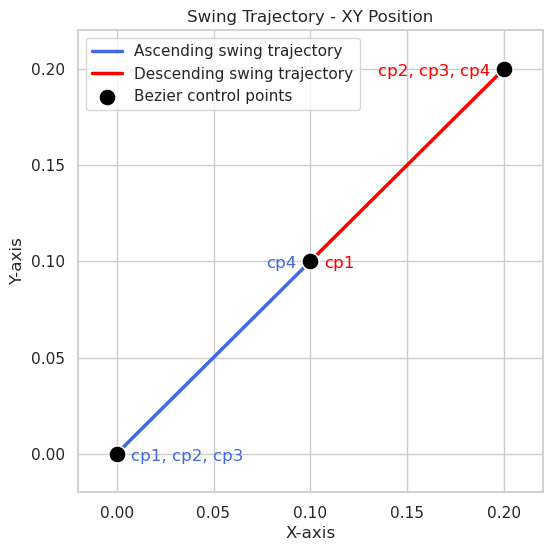

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_1, y=y_1, ax=ax, color=color_line_1, linewidth=2.5, label='Ascending swing trajectory')
sns.lineplot(x=x_2, y=y_2, ax=ax, color=color_line_2, linewidth=2.5, label='Descending swing trajectory')

# Add a dot plot on top of the spline
sns.scatterplot(x=torch.stack((cp0_1[0], cp1_1[0], cp2_1[0], cp3_1[0])), y=torch.stack((cp0_1[1], cp1_1[1], cp2_1[1], cp3_1[1])), ax=ax, color=color_scatter_1, s=150, label='Bezier control points', zorder=5)
sns.scatterplot(x=torch.stack((cp0_2[0], cp1_2[0], cp2_2[0], cp3_2[0])), y=torch.stack((cp0_2[1], cp1_2[1], cp2_2[1], cp3_2[1])), ax=ax, color=color_scatter_1, s=150, zorder=5)


# Annotate the control points
control_points = ['cp1, cp2, cp3']
for i, (x_val, y_val) in enumerate(zip([cp0_1[0]], [cp0_1[1]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(10,-5), color=text_color_1)
control_points = ['cp4']
for i, (x_val, y_val) in enumerate(zip([cp3_1[0]], [cp3_1[1]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(-10,-5), ha='right', color=text_color_1)
control_points = ['cp1']
for i, (x_val, y_val) in enumerate(zip([cp0_2[0]], [cp0_2[1]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(10,-5), ha='left', color=text_color_2)
control_points = ['cp2, cp3, cp4']
for i, (x_val, y_val) in enumerate(zip([cp3_2[0]], [cp3_2[1]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(-10,-5), ha='right', color=text_color_2)

# Add titles and labels
ax.set_title("Swing Trajectory - XY Position", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Y-axis", fontsize=12)

ax.set_xlim(-0.02, 0.22)
ax.set_ylim(-0.02, 0.22)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/xy_bezier_curve.pdf", bbox_inches='tight')
plt.show()


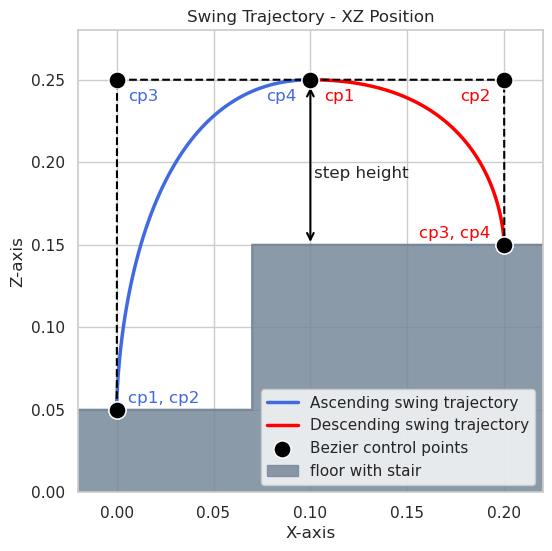

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style=style_theme)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the spline using Seaborn with custom color and line thickness
sns.lineplot(x=x_1, y=z_1, ax=ax, color=color_line_1, linewidth=2.5, label='Ascending swing trajectory')
sns.lineplot(x=x_2, y=z_2, ax=ax, color=color_line_2, linewidth=2.5, label='Descending swing trajectory')

sns.lineplot(x=torch.stack((cp0_1[0], cp1_1[0]+0.0001, cp2_1[0]+0.0002, cp3_1[0])), y=torch.stack((cp0_1[2], cp1_1[2], cp2_1[2], cp3_1[2])), ax=ax, color=color_scatter_1, linestyle='--')
sns.lineplot(x=torch.stack((cp0_2[0], cp1_2[0], cp2_2[0]+0.0001, cp3_2[0]+0.0001)), y=torch.stack((cp0_2[2], cp1_2[2], cp2_2[2], cp3_2[2])), ax=ax, color=color_scatter_1, linestyle='--')


# Add a dot plot on top of the spline
sns.scatterplot(x=torch.stack((cp0_1[0], cp1_1[0], cp2_1[0], cp3_1[0])), y=torch.stack((cp0_1[2], cp1_1[2], cp2_1[2], cp3_1[2])), ax=ax, color=color_scatter_1, s=150, label='Bezier control points', zorder=5)
sns.scatterplot(x=torch.stack((cp0_2[0], cp1_2[0], cp2_2[0], cp3_2[0])), y=torch.stack((cp0_2[2], cp1_2[2], cp2_2[2], cp3_2[2])), ax=ax, color=color_scatter_1, s=150, zorder=5)

# Annotate the control points
control_points = ['cp1, cp2']
for i, (x_val, y_val) in enumerate(zip([cp0_1[0]], [cp0_1[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(8,5), color=text_color_1)
control_points = ['cp3']
for i, (x_val, y_val) in enumerate(zip([cp2_1[0]], [cp2_1[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(8,-15), color=text_color_1)
control_points = ['cp4']
for i, (x_val, y_val) in enumerate(zip([cp3_1[0]], [cp3_1[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(-10,-15), ha='right', color=text_color_1)
control_points = ['cp1']
for i, (x_val, y_val) in enumerate(zip([cp0_2[0]], [cp0_2[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(10,-15), ha='left', color=text_color_2)
control_points = ['cp2']
for i, (x_val, y_val) in enumerate(zip([cp1_2[0]], [cp1_2[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(-10,-15), ha='right', color=text_color_2)
    control_points = ['cp3, cp4']
for i, (x_val, y_val) in enumerate(zip([cp3_2[0]], [cp3_2[2]])):
    ax.annotate(control_points[i], (x_val.item(), y_val.item()), textcoords="offset points", xytext=(-10,5), ha='right', color=text_color_2)


# add the stair
x = torch.tensor((-1.0, 0.07, 0.07001, 1.2))
y = torch.tensor((0.05, 0.05, 0.15, 0.15))
sns.lineplot(x=x, y=y, ax=ax, color=filled_color_1)
ax.fill_between(x, y, color=filled_color_1, alpha=0.85, label='floor with stair')

#  Draw a double-sided arrow
A = (0.10, 0.15)
B = (0.10, 0.247)
ax.annotate(
    '', xy=B, xytext=A,
    arrowprops=dict(arrowstyle='<->', color='black', lw=1.5)
)
ax.text((A[0] + B[0]) / 2 + 0.002, (A[1] + B[1]) / 2 - 0.005, 'step height', fontsize=12, ha='left', va='center')


# Add titles and labels
ax.set_title("Swing Trajectory - XZ Position", fontsize=12)
ax.set_xlabel("X-axis", fontsize=12)
ax.set_ylabel("Z-axis", fontsize=12)

ax.set_xlim(-0.02, 0.22)
ax.set_ylim(0.0, 0.28)

# Add legend
ax.legend()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/z_bezier_curve.pdf", bbox_inches='tight')
plt.show()


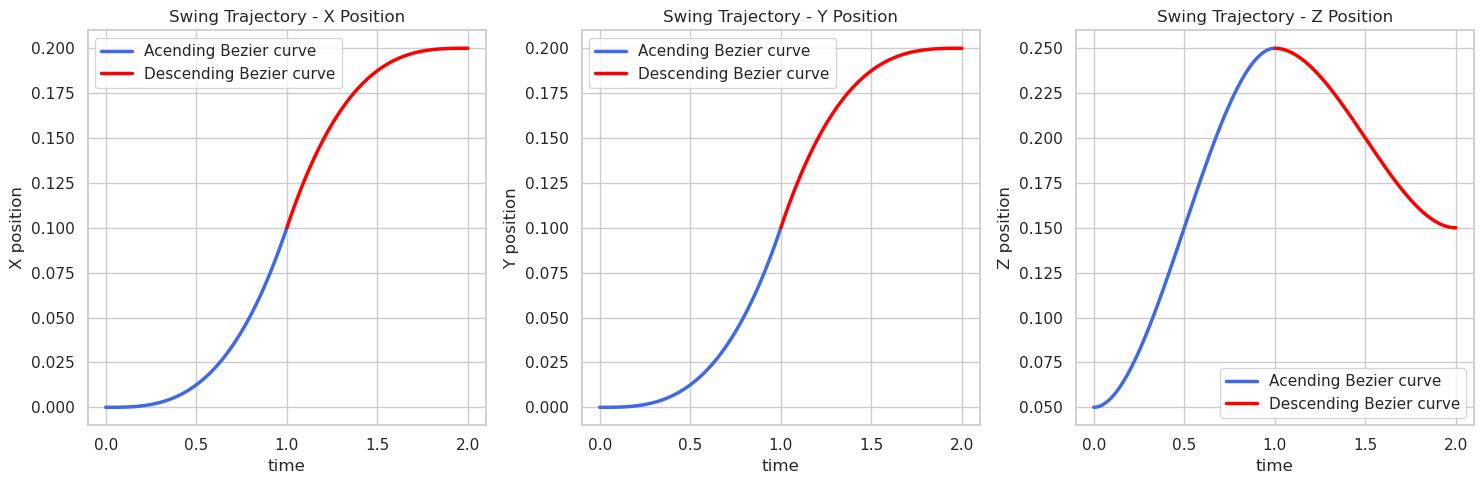

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming t, x_1, x_2, y_1, y_2, z_1, z_2 are defined
# and style_theme, color_line_1 are also defined

sns.set_theme(style=style_theme)

# Create a figure and a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

label_1 = 'Acending Bezier curve'
label_2 = 'Descending Bezier curve'

# Plot x position on the first subplot
sns.lineplot(x=t, y=x_1, ax=axes[0], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=x_2, ax=axes[0], color=color_line_2, linewidth=2.5, label=label_2)
axes[0].set_title("Swing Trajectory - X Position", fontsize=12)
axes[0].set_xlabel("time", fontsize=12)
axes[0].set_ylabel("X position", fontsize=12)
axes[0].legend()

# Plot y position on the second subplot
sns.lineplot(x=t, y=y_1, ax=axes[1], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=y_2, ax=axes[1], color=color_line_2, linewidth=2.5, label=label_2)
axes[1].set_title("Swing Trajectory - Y Position", fontsize=12)
axes[1].set_xlabel("time", fontsize=12)
axes[1].set_ylabel("Y position", fontsize=12)
axes[1].legend()

# Plot z position on the third subplot
sns.lineplot(x=t, y=z_1, ax=axes[2], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=z_2, ax=axes[2], color=color_line_2, linewidth=2.5, label=label_2)
axes[2].set_title("Swing Trajectory - Z Position", fontsize=12)
axes[2].set_xlabel("time", fontsize=12)
axes[2].set_ylabel("Z position", fontsize=12)
axes[2].legend()#loc='lower right')

# axes[2].set_xlim(-0.1, 2.1)
# axes[2].set_ylim(0.0, 0.28)

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/xyz_position_bezier_curve.pdf", bbox_inches='tight')
plt.show()


## Swing traj 3D plot for report

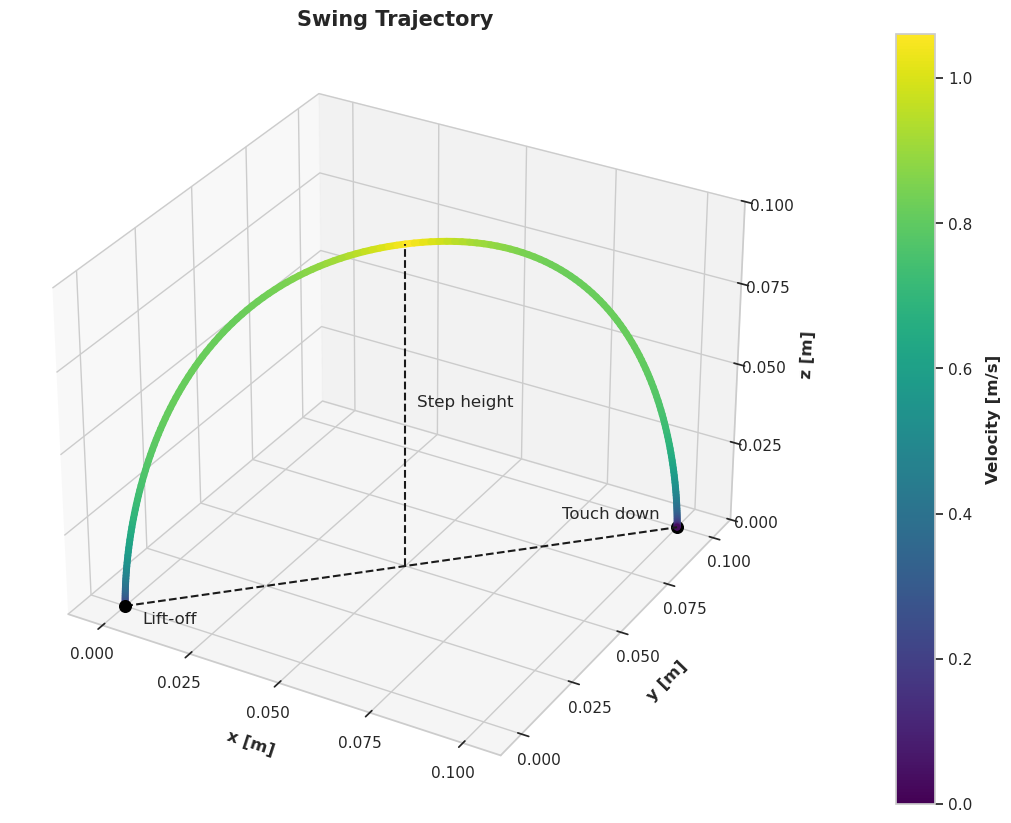

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Sample data (use your actual data here)
# p_x, p_y, p_z, v_x, v_y, v_z = np.array([...]), np.array([...]), np.array([...]), np.array([...]), np.array([...]), np.array([...])

p_x = np.concatenate([x_1,x_2])
p_y = np.concatenate([y_1,y_2])
p_z = np.concatenate([z_1,z_2])

v_x = np.concatenate([x_dot_1,x_dot_2])*5
v_y = np.concatenate([y_dot_1,y_dot_2])*5
v_z = np.concatenate([z_dot_1,z_dot_2])*5

# Compute the norm of the velocity
velocity_norm = np.sqrt((v_x**2) + (v_y**2) + (v_z**2))

# Normalize the velocity norm for color mapping
norm = plt.Normalize(velocity_norm.min(), velocity_norm.max())

# Create a color map
cmap = plt.cm.viridis

# Create a 3D plot
sns.set_style(style="whitegrid")

# Create a figure and a 3D axis
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
for i in range(len(p_x)-1):
    ax.plot(p_x[i:i+2], p_y[i:i+2], p_z[i:i+2], color=cmap(norm(velocity_norm[i])), linewidth=5)


# Label specific points
ax.scatter(p_x[0], p_y[0], p_z[0], s=70, label='Lift-off' , color='black')
ax.scatter(p_x[-1], p_y[-1], p_z[-1], s=70, label='Touch down', color='black')

middle_index = len(p_x) // 2
# ax.scatter(p_x[middle_index], p_y[middle_index], p_z[middle_index], color='black', s=100, label='Step height')
# ax.text(p_x[middle_index], p_y[middle_index], p_z[middle_index], ' Step height', color='blue')

# Label the midpoint of the dashed line
midpoint_x = p_x[middle_index]
midpoint_y = p_y[middle_index]
midpoint_z = (0 + p_z[middle_index]) / 2
offset = 0.002  # Adjust as needed
ax.text(midpoint_x + offset, midpoint_y + offset, midpoint_z, 'Step height')#, color='blue', fontsize=12)


# Dashed line between lift-off and touch down in the XY plane
ax.plot([p_x[0], p_x[-1]], [p_y[0], p_y[-1]], [p_z[0], p_z[0]], 'k--')

# Dashed line between step height in the XY plane and step height point
ax.plot([p_x[middle_index], p_x[middle_index]], [p_y[middle_index], p_y[middle_index]], [0, p_z[middle_index]], 'k--')


# Create a color bar
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(velocity_norm)
cbar = plt.colorbar(mappable, ax=ax, pad=0.1)



# Set the labels on the XY plane and adjust their positions
ax.text(p_x[0]+0.005, p_y[0], 0, 'Lift-off',fontsize=12, ha='left', va='top') #color='red', 
ax.text(p_x[-1]-0.005, p_y[-1], 0, 'Touch down', fontsize=12, ha='right', va='bottom') # color='red', 




# Add color bar for reference
# fig.colorbar(surf, shrink=0.5, aspect=5)

# Add titles and labels
ax.set_title('Swing Trajectory', fontsize=15, fontweight='bold')
ax.set_xlabel('x [m]', fontsize=12, labelpad=10, fontweight='bold')#, fontweight='bold')
ax.set_ylabel('y [m]', fontsize=12, labelpad=10, fontweight='bold')
ax.set_zlabel('z [m]', fontsize=12, labelpad=10, fontweight='bold')
cbar.set_label('Velocity [m/s]', fontsize=12, labelpad=10, fontweight='bold')



min_x, max_x = 0.00, 0.10
min_y, max_y = 0.00, 0.10
min_z, max_z = 0.00, 0.10
ax.set_xlim(min_x-0.01, max_x+0.01)
ax.set_ylim(min_y-0.01, max_y+0.01)
ax.set_zlim(min_z, max_z)
# Customize tick intervals
ax.set_xticks(np.linspace(min_x, max_x, 5))
ax.set_yticks(np.linspace(min_y, max_y, 5))
ax.set_zticks(np.linspace(min_z, max_z, 5))
# ax.grid(True, linestyle='--', color='gray', linewidth=0.5)

plt.savefig("thesis image/4.5/swing_traj.pdf", bbox_inches='tight')

# Show plot
plt.show()


## Swing Trajectory Velocity

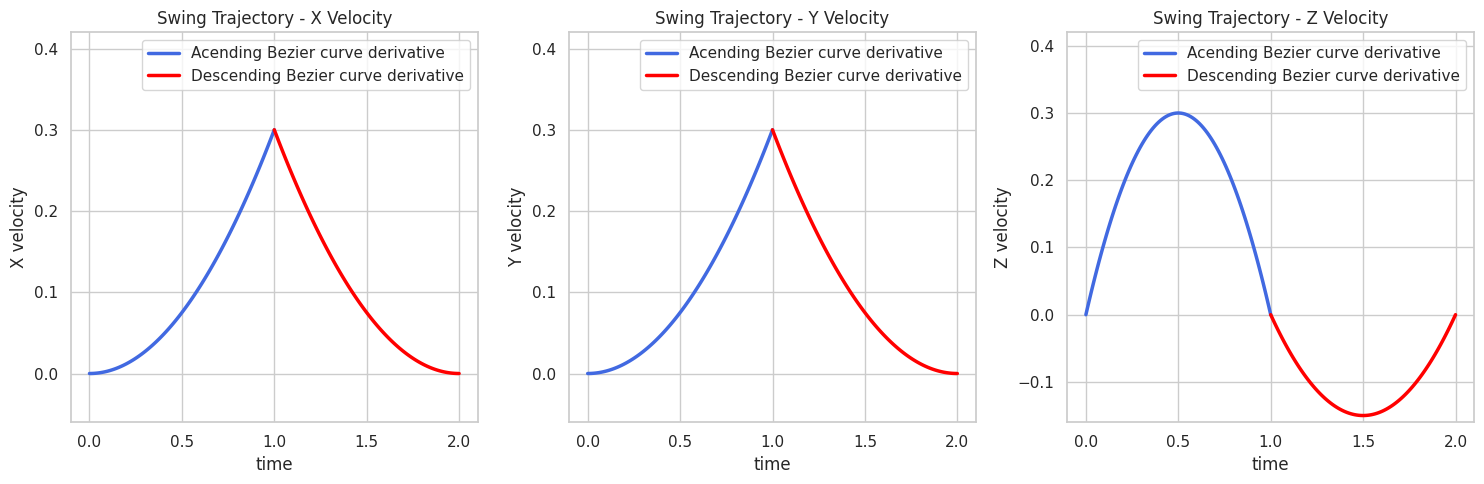

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming t, x_dot_1, x_dot_2, y_dot_1, y_dot_2, z_dot_1, z_dot_2 are defined
# and style_theme, color_line_1, and color_line_2 are also defined

sns.set_theme(style=style_theme)

label_1 = 'Acending Bezier curve derivative'
label_2 = 'Descending Bezier curve derivative'

# Create a figure and a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot x velocity on the first subplot
sns.lineplot(x=t, y=x_dot_1, ax=axes[0], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=x_dot_2, ax=axes[0], color=color_line_2, linewidth=2.5, label=label_2)
axes[0].set_title("Swing Trajectory - X Velocity", fontsize=12)
axes[0].set_xlabel("time", fontsize=12)
axes[0].set_ylabel("X velocity", fontsize=12)
# axes[0].legend()
axes[0].set_ylim(-0.06, 0.42)

# Plot y velocity on the second subplot
sns.lineplot(x=t, y=y_dot_1, ax=axes[1], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=y_dot_2, ax=axes[1], color=color_line_2, linewidth=2.5, label=label_2)
axes[1].set_title("Swing Trajectory - Y Velocity", fontsize=12)
axes[1].set_xlabel("time", fontsize=12)
axes[1].set_ylabel("Y velocity", fontsize=12)
axes[1].legend()
axes[1].set_ylim(-0.06, 0.42)

# Plot z velocity on the third subplot
sns.lineplot(x=t, y=z_dot_1, ax=axes[2], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=z_dot_2, ax=axes[2], color=color_line_2, linewidth=2.5, label=label_2)
axes[2].set_title("Swing Trajectory - Z Velocity", fontsize=12)
axes[2].set_xlabel("time", fontsize=12)
axes[2].set_ylabel("Z velocity", fontsize=12)
axes[2].legend()

axes[2].set_ylim(-0.16, 0.42)

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/xyz_dot_bezier_curve.pdf", bbox_inches='tight')
plt.show()


## Swing trajectory Acceleration

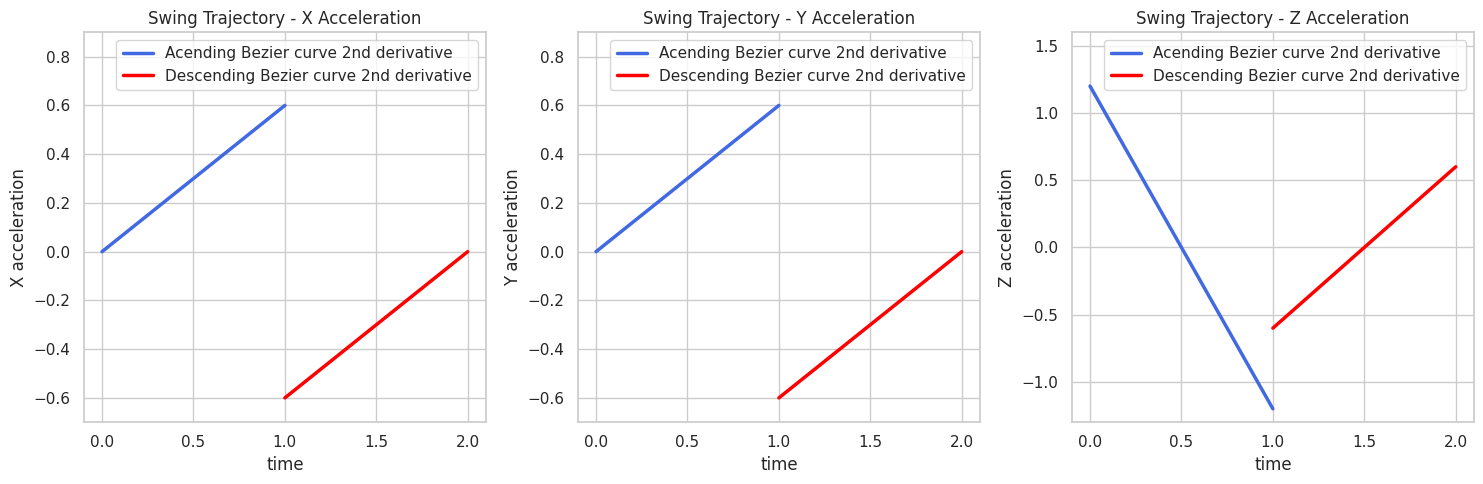

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming t, x_dot_dot_1, x_dot_dot_2, y_dot_dot_1, y_dot_dot_2, z_dot_dot_1, z_dot_dot_2 are defined
# and style_theme, color_line_1, and color_line_2 are also defined
sns.set_theme(style=style_theme)
# sns.set_context("paper")

# Create a figure and a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

label_1 = 'Acending Bezier curve 2nd derivative'
label_2 = 'Descending Bezier curve 2nd derivative'

# Plot x acceleration on the first subplot
sns.lineplot(x=t, y=x_dot_dot_1, ax=axes[0], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=x_dot_dot_2, ax=axes[0], color=color_line_2, linewidth=2.5, label=label_2)
axes[0].set_title("Swing Trajectory - X Acceleration", fontsize=12)
axes[0].set_xlabel("time", fontsize=12)
axes[0].set_ylabel("X acceleration", fontsize=12)
axes[0].legend(loc='upper right')
axes[0].set_ylim(-0.7, 0.9)

# Plot y acceleration on the second subplot
sns.lineplot(x=t, y=y_dot_dot_1, ax=axes[1], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=y_dot_dot_2, ax=axes[1], color=color_line_2, linewidth=2.5, label=label_2)
axes[1].set_title("Swing Trajectory - Y Acceleration", fontsize=12)
axes[1].set_xlabel("time", fontsize=12)
axes[1].set_ylabel("Y acceleration", fontsize=12)
axes[1].legend(loc='upper right')
axes[1].set_ylim(-0.7, 0.9)

# Plot z acceleration on the third subplot
sns.lineplot(x=t, y=z_dot_dot_1, ax=axes[2], color=color_line_1, linewidth=2.5, label=label_1)
sns.lineplot(x=t+1, y=z_dot_dot_2, ax=axes[2], color=color_line_2, linewidth=2.5, label=label_2)
axes[2].set_title("Swing Trajectory - Z Acceleration", fontsize=12)
axes[2].set_xlabel("time", fontsize=12)
axes[2].set_ylabel("Z acceleration", fontsize=12)
axes[2].legend(loc='upper right')
axes[2].set_ylim(-1.3, 1.6)

# Adjust layout
plt.tight_layout()

# Save the plot as a PDF for high-quality output in LaTeX
plt.savefig("thesis image/B/xyz_dot_dot_bezier_curve.pdf", bbox_inches='tight')
plt.show()


# Soft Exp Kernel

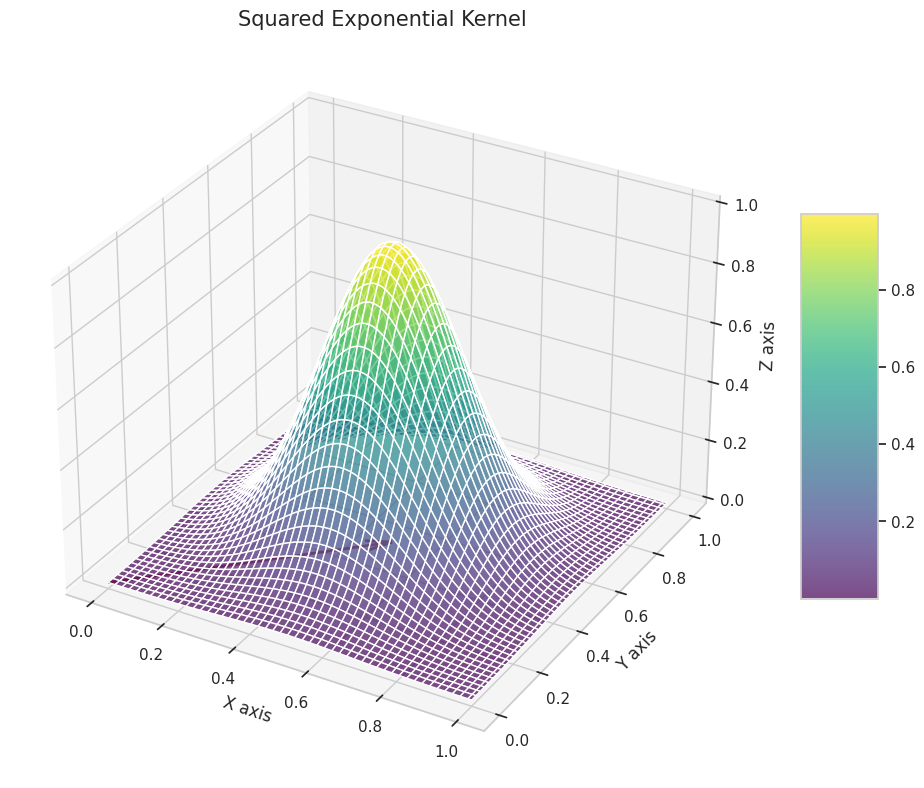

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Set the Seaborn style
sns.set_theme(style="whitegrid")

v = np.array([0.5,0.5])
std = 0.25

# Define the function f(x, y)
def f(x, y):
    lin_err = (v[0] - x)**2 + (v[1] - y)**2
    return np.exp(-lin_err/(std**2))
    # return np.sin(np.sqrt(x**2 + y**2))

# Create a grid of x, y values
x = np.linspace(0.0, 1, 100)
y = np.linspace(0.0, 1, 100)
x, y = np.meshgrid(x, y)
z = f(x, y)

# Create a figure and a 3D axis
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with transparency
surf = ax.plot_surface(x, y, z, cmap='viridis', alpha=0.7)#,  zorder=1)  # alpha controls transparency

# Add color bar for reference
fig.colorbar(surf, shrink=0.5, aspect=5)

# Draw the arrow in the xy-plane
ax.quiver(0, 0, 0, v[0], v[1], 0, color='r', arrow_length_ratio=0.1,  linewidth=2, zorder=40)

x_line = [0.5, 0.5]
y_line = [0.5, 0.5]
z_line = [0.0, 1.0]
# ax.plot(x_line, y_line, z_line, linestyle='--', color='r',  linewidth=2, zorder=30)

# ax.scatter(0.5, 0.5, 1.0, s=50, color='r', zorder=31, label='Scatter point')

# Add titles and labels
ax.set_title('Squared Exponential Kernel', fontsize=15)
ax.set_xlabel('X axis', fontsize=12)
ax.set_ylabel('Y axis', fontsize=12)
ax.set_zlabel('Z axis', fontsize=12)

plt.savefig("thesis image/D/squared_exponential.pdf", bbox_inches='tight')

# Show the plot
plt.show()


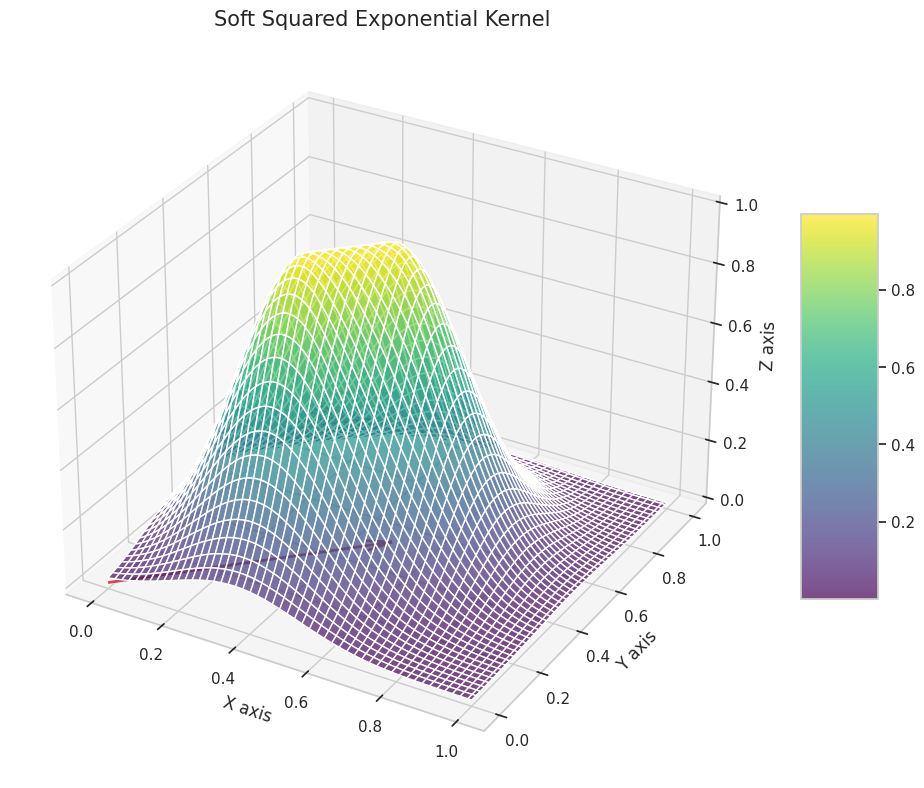

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Set the Seaborn style
sns.set_theme(style="whitegrid")


v = np.array([0.5,0.5])
std = 0.25
alpha=0.2

# Define the function f(x, y)
def f(vx, vy):

    v_ref_norm = ((v[0]**2) + (v[1]**2))**(0.5)

    forward_error = -v_ref_norm + ((v[0]*vx + v[1]*vy)/(v_ref_norm))
    lateral_error = -(v[1]*vx - v[0]*vy)/(v_ref_norm)

    x_sup_0 = forward_error >= 0.0
    # x_in_0_alpha = (forward_error >= -alpha) and (forward_error <= 0)
    x_inf_alpha = forward_error < -alpha

    h_forward_error = 0.0 + (forward_error*x_sup_0) + ((forward_error + alpha)*x_inf_alpha) #+ (0 * x_in_0_alpha) 
    # h_forward_error = forward_error

    return np.exp(-((h_forward_error**2) + (lateral_error**2))/(std**2))
    # return np.sin(np.sqrt(x**2 + y**2))

# Create a grid of x, y values
x = np.linspace(0.0, 1, 100)
y = np.linspace(0.0, 1, 100)
x, y = np.meshgrid(x, y)
z = f(x, y)

# Create a figure and a 3D axis
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with transparency
surf = ax.plot_surface(x, y, z, cmap='viridis', alpha=0.7)#,  zorder=1)  # alpha controls transparency

# Add color bar for reference
fig.colorbar(surf, shrink=0.5, aspect=5)


# Draw the arrow in the xy-plane
ax.quiver(0, 0, 0, v[0], v[1], 0, color='r', arrow_length_ratio=0.1,  linewidth=2, zorder=40)

# x_line = [0.5, 0.5]
# y_line = [0.5, 0.5]
# z_line = [0.0, 1.0]
# ax.plot(x_line, y_line, z_line, linestyle='--', color='r',  linewidth=2, zorder=30)

# ax.scatter(0.5, 0.5, 1.0, s=50, color='r', zorder=31, label='Scatter point')

# Add titles and labels
ax.set_title('Soft Squared Exponential Kernel', fontsize=15)
ax.set_xlabel('X axis', fontsize=12)
ax.set_ylabel('Y axis', fontsize=12)
ax.set_zlabel('Z axis', fontsize=12)

plt.savefig("thesis image/D/soft_squared_exponential.pdf", bbox_inches='tight')

# Show the plot
plt.show()


# Gait Plot - Hildebrand style diagram

/tmp/ipykernel_10007/3731113867.py:73: FutureWarning: The provided callable <function nanmean at 0x757060162b90> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  summary = df.pivot_table(index='Side', values=['TD_p', 'TO_p'],


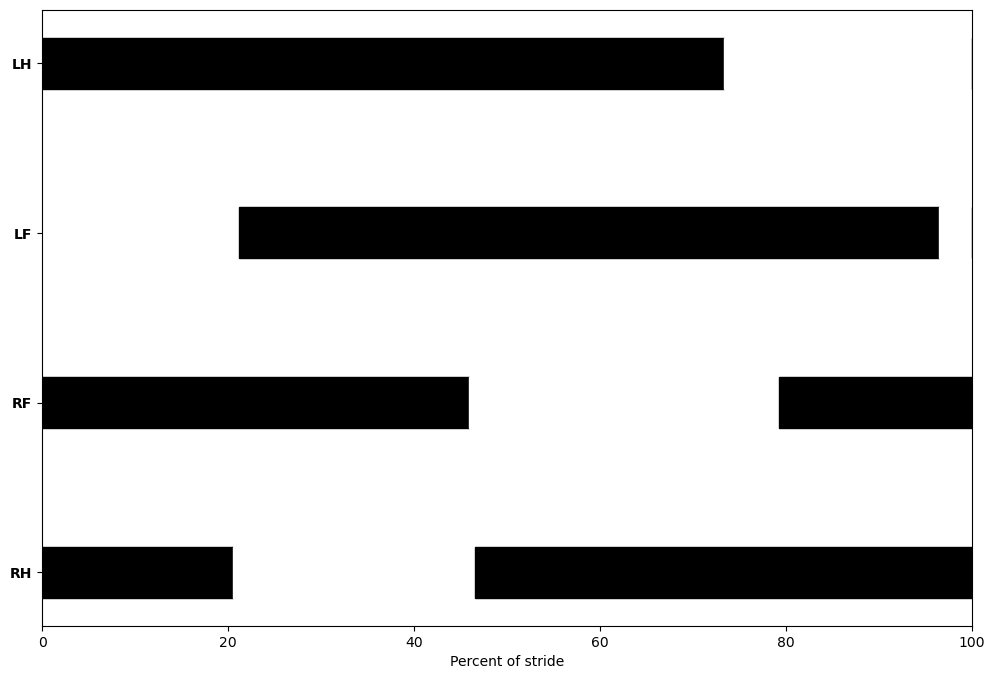

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def convert_frame(frame, start, end):
    """
    Given a frame, converts it to % of total (using reference frames for start and end of the stride; typically start
    is the first contact of the left hind foot, and end is the next contact of that same foot.
    Note that 100 and 200 were chosen for stride cycles of a tapir filmed at 240fps. You may need to expand the range
    for your data, always keeping 'out' between 0 and 100.
    You could probably programmatically subtract the correct number of hundreds but I'm lazy and this is my data.
    :param frame:
    :param start:
    :param end:
    :return:
    """
    out = (frame - start) / (end - start) * 100
    if out <= 100:
        return out
    elif out <= 200:
        return out - 100
    else:
        return out - 200


def define_plot_values(td, to):
    """
    For a stacked bar chart of white black white black, fill in the values. The structure varies because sometimes the
    strides loop after 100%; so we set up a dictionary with values for wbwb to do a stacked bar chart.
    :param td: toe-down of that foot
    :param to: toe-off of that foot
    :return:
    """
    if td == 0:  # for LH: no white, black from 0 to toe off, white from there to 100, no black
        plotvals = [0, to, 100 - to, 0]
        err_td = 0
        err_to = 1
        # error for TO goes on the b1 bar
    elif td < to:  # for when TD happens after 0 but no wrapping: white to td, black to to, white to 100, no black
        plotvals = [td, to - td, 100 - to, 0]
        err_td = 0
        err_to = 3
        # TD error goes on w2, TO error goes on b2
    else:  # when it wraps around: no white, black to TO, white between TO and TD, black to 100
        plotvals = [0, to, td - to, 100 - td]
        err_td = 2
        err_to = 1
        # TD error goes on w2, TO error goes on b1

    return plotvals, (err_td, err_to)


if __name__ == '__main__':
    df = pd.read_csv("thesis image/4.5/contact_frames.csv")

    steps = df.drop_duplicates(subset=['Trial', 'Pass', 'Step'], inplace=False).reset_index(drop=True)
    footvals = ['LH', 'LF', 'RF', 'RH']
    # For every trial, pass, and step combination:
    for i in range(len(steps.index)):
        start = steps['TD'][i]
        try:
            end = steps['TD'][i + 1]
        except KeyError:
            break
        # Rows of interest: rows corresponding to step i
        roi = df[df['Step'] == steps['Step'][i]].index
        # Convert TD and TO into % of total
        df.loc[roi, 'TD_p'] = df.iloc[roi]['TD'].apply(convert_frame, args=(start, end))
        df.loc[roi, 'TO_p'] = df.iloc[roi]['TO'].apply(convert_frame, args=(start, end))

    # Get the average and standard error of the TD and TO values for each foot
    summary = df.pivot_table(index='Side', values=['TD_p', 'TO_p'],
                             aggfunc=[np.nanmean, lambda x: np.nanstd(x)/np.sqrt(len(x))]).reindex(footvals[::-1])
    plotvals = []
    # TODO: find an easy way of setting up error values in the correct places.
    #       note that the define_plot_values function does a quick and dirty job of saying which bar the error should
    #       go on, but I think there's probably a cleaner way to do it. That's a problem for the future, and may be
    #       easier if the rest of this code is cleaned up a little too.

    # For each TD/TO pairing, calculate where the white and black bars should go
    for foot in list(zip(summary['nanmean']['TD_p'], summary['nanmean']['TO_p'])):
        err_array = [0, 0, 0, 0]
        pv, err = define_plot_values(foot[0], foot[1])
        plotvals.append(pv)

    # Transpose the data into white/black instead of td/to
    w1 = [x[0] for x in plotvals]
    b1 = [x[1] for x in plotvals]
    w2 = [x[2] for x in plotvals]
    b2 = [x[3] for x in plotvals]

    # The position of the bars on the x-axis
    r = [0, 1, 2, 3]

    df_figure = plt.figure(figsize=(12, 8))
    # With thanks to http://python-graph-gallery.com/12-stacked-barplot-with-matplotlib/
    # In order, plot the white, black, white, black
    # Note how each bar has to start at the end of the previous (with left = _)
    plt.barh(r, w1, color='white', edgecolor='white', height=0.3)
    plt.barh(r, b1, left=w1, color='black', edgecolor='black', height=0.3)  # use xerr = _ to set the errors
    plt.barh(r, w2, left=np.add(b1, w1), color='white', edgecolor='white', height=0.3)
    plt.barh(r, b2, left=np.add(np.add(b1, w1), w2), color='black', edgecolor='black', height=0.3)

    # Set the y axis accordingly
    plt.yticks(r, footvals[::-1], fontweight='bold')
    plt.xlabel("Percent of stride")

    plt.show()

    # df_figure.savefig(fname="figures/stridestride_cycle.jpg")